In [1]:
from __future__ import print_function, division
import os

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import io, transform
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
from copy import deepcopy
import random

from moviepy.editor import VideoFileClip,ImageSequenceClip
from IPython.display import HTML
import matplotlib.image as mpimg

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import cv2

import pickle
from pylab import *
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

%matplotlib inline
# %matplotlib notebook

In [ ]:
use_history = True
weights_file_name = 'CNN_weather_and_history'

use_history = False
weights_file_name = 'CNN_weather_only'

In [2]:
which_data = 'Data_2015_DES_I235E'
(Traffic_2015,Weather_2015,data_2015) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2015['y'][0][:4]
print('{} data loaded'.format(year))

which_data = 'Data_2016_DES_I235E'
(Traffic_2016,Weather_2016,data_2016) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2016['y'][0][:4]
print('{} data loaded'.format(year))

data = pd.concat([data_2015,data_2016],ignore_index=True)
Traffic = np.concatenate([Traffic_2015, Traffic_2016],axis = 0)
Weather_5min = np.concatenate([Weather_2015, Weather_2016],axis = 0)
Weather = np.zeros([Weather_5min.shape[0],Weather_5min.shape[1],Weather_5min.shape[2]*5,Weather_5min.shape[3]])
for i in range(Weather.shape[2]):
    Weather[:,:,i,:] = Weather_5min[:,:,int(i/5),:]
Weather = np.delete(Weather,1,axis=3)

2015 data loaded
2016 data loaded


In [3]:
class CNN_SpeedPrediction_database(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6):

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
#         printdb_trans_1 = Dataset_NVIDIA_1(annotation_list,frame_list,transform = PerspectiveTransform(MAP_FILE, world_origin, pixel_ratio, PMAT_FILE))(self.__len__())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        Traffic_today = self.Traffic[idx,:,:,:]
        Weather_today = self.Weather[idx,:,:,:]
        Traffic_history = 0 
        Traffic_output = self.Traffic[idx,:,:,0]
        
        dayofweek = self.data.loc[idx]['dayofweek']
        data_sub = self.data[:idx]
        sameday_in_history = data_sub.index[data_sub['dayofweek'] == dayofweek].tolist()
        
#         Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
        
        Traffic_history = [self.Traffic[idx,:,:,:]+np.random.randn(15,1440,3) for _ in range(self.look_back)]
        Traffic_history = np.stack(Traffic_history,0)
        
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[self.look_back-len(sameday_in_near_history)+i] = self.Traffic[sameday_in_near_history[i]]
        
        sample = {'weather': torch.Tensor(Weather_today), 'history': torch.Tensor(Traffic_history), 'label': torch.Tensor(Traffic_output)} # 

        if self.transform:
            sample = self.transform(sample)
        return sample

In [4]:
db = CNN_SpeedPrediction_database(Traffic, Weather, data)

X                      20161216Dir1.csv
y             20161216_Traffic_Dir1.csv
day                            20161216
date                2016-12-16 00:00:00
dayofweek                             4
weekofyear                           50
month                                12
dayofyear                           351
Name: 431, dtype: object
dict_keys(['weather', 'history', 'label'])
torch.Size([6, 15, 1440, 3])
torch.Size([15, 1440, 9])
torch.Size([15, 1440])


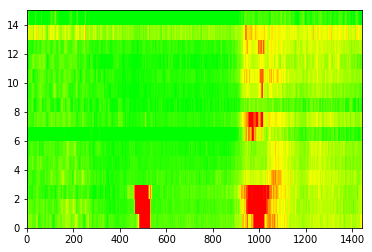

In [5]:
idx = 431  # test: [417,420,431]
print(data.loc[idx])

def vis_one_day_traffic_speed(speed):
    plt.pcolor(speed,cmap=my_cmap, vmin=20, vmax=70)
    
# vis_one_day_traffic_speed(db[257]['label'])
print(db[idx].keys())
print(db[idx]['history'].shape)
print(db[idx]['weather'].shape)
print(db[idx]['label'].shape)
vis_one_day_traffic_speed(db[idx]['label']) 

In [6]:
data_train = data[:-30]
data_train = data_train.reset_index()

data_val = data[-61:]
data_val = data_val.reset_index()

dataset = {}
dataset['train'] = CNN_SpeedPrediction_database(Traffic[:-30], Weather[:-30], data_train)
dataset['val'] = CNN_SpeedPrediction_database(Traffic[-61:], Weather[-61:], data_val)

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=1000,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [7]:
'''https://github.com/wkelongws/iemgrid'''
'''Weather: 0:tmpc 1:dwpc 2:smps 3:drct 4:vsby 5:roadtmpc 6:srad 7:snwd 8:pcpn '''

Traffic_max = []
Traffic_min = []
Weather_max = []
Weather_min = []

for i in range(Traffic.shape[-1]):
#     print(i,'max: ',np.max(Traffic[:,:,:,i]))
    Traffic_max.append(np.max(Traffic[:,:,:,i]))
#     print(i,'mean: ',np.mean(Traffic[:,:,:,i]))
#     print(i,'min: ',np.min(Traffic[:,:,:,i]))
    Traffic_min.append(np.min(Traffic[:,:,:,i]))
for i in range(Weather.shape[-1]):
#     print(i,'max: ',np.max(Weather[:,:,:,i]))
    Weather_max.append(np.max(Weather[:,:,:,i]))
#     print(i,'mean: ',np.mean(Weather[:,:,:,i]))
#     print(i,'min: ',np.min(Weather[:,:,:,i]))
    Weather_min.append(np.min(Weather[:,:,:,i]))
    
Min_Max = (Traffic_max,Traffic_min,Weather_max,Weather_min)

In [8]:
cnt = 0
for sample in dataloaders['train']:
    cnt += 1
    if cnt == 1:
        s = sample
    c = sample['weather']
    d = sample['history']
    e = sample['label']
    print('weather: ',sample['weather'].shape)
    print('history: ',sample['history'].shape)
    print('label: ',sample['label'].shape)

weather:  torch.Size([417, 15, 1440, 9])
history:  torch.Size([417, 6, 15, 1440, 3])
label:  torch.Size([417, 15, 1440])


In [36]:
class CNN_Long_Term_Speed_Pred_Net(nn.Module):
    def __init__(self, use_gpu = True, use_history = True, Min_Max = Min_Max):
        super(CNN_Long_Term_Speed_Pred_Net, self).__init__()
        
        self.use_gpu = use_gpu
        self.use_history = use_history

        '''for on-fly normalization'''
        self.Traffic_max = Min_Max[0]
        self.Traffic_min = Min_Max[1]
        self.Weather_max = Min_Max[2]
        self.Weather_min = Min_Max[3]
        
        self.weather_layer1_conv2d = nn.Conv2d(in_channels=9, out_channels=2, kernel_size=(1,1))
        self.weather_layer2_conv2d = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=(3,3))
        self.weather_layer3_conv2d = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3,3))
        
        self.history_layer1_conv3d = nn.Conv3d(in_channels=1, out_channels=2, kernel_size=(3,3,3))
        self.history_layer2_conv2d = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=(1,1))
        self.history_layer3_conv2d = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3,3))
        
        self.decoder_layer1_conv2d = nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=(3,3))
        self.decoder_layer2_conv2d = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(3,3))

    def forward(self, input_sample, future = 0, use_gpu = True):
        
        '''reconstruct data from sample'''
        weather = input_sample['weather']
        history = input_sample['history']
        label = input_sample['label']
        
        '''normalize'''
#         label = (label - self.Traffic_min[0])/(self.Traffic_max[0]-self.Traffic_min[0])
        for i in range(history.shape[-1]):
            history[:,:,:,:,i] = (history[:,:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
        for i in range(weather.shape[-1]):
            weather[:,:,:,i] = (weather[:,:,:,i]-self.Weather_min[i])/(self.Weather_max[i]-self.Weather_min[i])
        
        '''re-arrange inputs'''
        input_history = history[:,:,:,:,0].unsqueeze(1)
        input_weather = weather.permute(0,3,1,2)
            
        if use_gpu:
            input_history = Variable(input_history.cuda())
            input_weather = Variable(input_weather.cuda())
            label = Variable(label.cuda())
        else:
            input_history = Variable(input_history)
            input_weather = Variable(input_weather)
            label = Variable(label)
        
        '''feedforward'''
        weather_feature_map_1 = self.weather_layer1_conv2d(input_weather)
        weather_feature_map_2 = self.weather_layer2_conv2d(weather_feature_map_1)
        weather_feature_map_3 = self.weather_layer3_conv2d(weather_feature_map_2)
        encoded_feature_map = weather_feature_map_3
        
        if self.use_history:
            history_feature_map_1 = self.history_layer1_conv3d(input_history)
            history_feature_map_1 = torch.cat([history_feature_map_1[:,i,:,:,:] for i in range(history_feature_map_1.shape[1])],1)
            history_feature_map_2 = self.history_layer2_conv2d(history_feature_map_1)
            history_feature_map_3 = self.history_layer3_conv2d(history_feature_map_2)
            encoded_feature_map += history_feature_map_3
        
        upsampled_feature_map = self.decoder_layer1_conv2d(encoded_feature_map)
        output = self.decoder_layer2_conv2d(upsampled_feature_map).squeeze(1)
        output = output*(self.Traffic_max[0]-self.Traffic_min[0])+self.Traffic_min[0] 
        
        return output, label
        

In [37]:
use_gpu = torch.cuda.is_available()
# use_gpu = False

model = CNN_Long_Term_Speed_Pred_Net(use_gpu = use_gpu, use_history = use_history, Min_Max = Min_Max)

if use_gpu:
    model = model.cuda()

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters())

In [ ]:
def train_CNN_LongTerm_SP_Net(model,dataloaders, criterion, optimizer, dataset_sizes, num_epochs=100, weights_file_name = weights_file_name):
    since = time.time()

#     timeSince(since)
#     model.load_state_dict(torch.load('Best_LSTM_Weights_1st'))
#     print()
#     print('keep training from previous "Best_LSTM_Weights_1st"')
#     print()

#     vanillaPlus_compromised_dict = torch.load('Best_LSTM_Weights_vanillaPlus')
#     vanillaPlus_compromised_dict['linear_out.weight'] = torch.randn(model.state_dict()['linear_out.weight'].shape).cuda()
#     vanillaPlus_compromised_dict['linear_out.bias'] = torch.randn(model.state_dict()['linear_out.bias'].shape).cuda()
#     model.load_state_dict(vanillaPlus_compromised_dict)
#     print()
#     print('weights in the output layer are initialized from normal distribution')
#     print('and other model weights are loaded from "Best_LSTM_Weights_vanillaPlus_compromised')
#     print('keep training from previous "Best_LSTM_Weights_vanillaPlus_compromised"')
#     print()

    best_model_wts = model.state_dict()
    best_loss = 100000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample in dataloaders[phase]:

                # zero the parameter gradients
                model.zero_grad()
                optimizer.zero_grad()
                
                # Also, we need to clear out the hidden state of the LSTM,
                # detaching it from its history on the last instance.
#                 model.hidden = model.init_hidden()
                
                # forward
                pred,label = model(sample)
                
                # loss function
#                 loss = customized_loss(pred,label)
                loss = criterion(pred,label)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f} total elapsed time: {}'.format(phase, epoch_loss, timeSince(since)))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, weights_file_name)
                print('Weights saved to {}'.format(weights_file_name))
                print()
                pickle.dump( losses, open( 'loss_log_'+weights_file_name+'_.p', "wb" ) )

        print()

    print('Training complete in {}'.format(timeSince(since)))
    print('Best val loss: {:4f}'.format(best_loss))
    
    # load best model weights
#     model.load_state_dict(best_model_wts)
#     torch.save(model, 'Model_with_Best_CNN_Weights')
#     print('Model saved to "Model_with_Best_CNN_Weights"')
    return model

In [ ]:
model_ft = train_CNN_LongTerm_SP_Net(model,dataloaders, criterion, optimizer, dataset_sizes, num_epochs=1000)